# Data exploration of current dataset

In [1]:
import pathlib2
import pandas as pd
import numpy as np
import json
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pprint

In [2]:
## Helper functions

def check_noneffective_ids(df):
    """
    check if the given data frame has NaN and return the rows with it if any, or else return nothing
    :param df: input dataframe
    :return: the non effective rows of the dataframe
    """
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    len_rows_with_NaN = rows_with_NaN.shape[0]
    if len_rows_with_NaN != 0:
        print(f"there are {len_rows_with_NaN} non effective rows.")
        return rows_with_NaN
    else:
        print("the rows available are all effective, i.e., without NaNs.")
        return None

def check_statistics_basics(df, ds_path, verbose=False):
    """
    check the basic statistics of training metadata and return some of them
    :param df: pd.DataFrame the dataframe of training metadata
    :param ds_path: the project path
    :param verbose: flag indicating whether the additional info is desired
    :return: dict containing the key for cell type and the value for respective counting in terms of different image ids
    """

    # check the rows of df
    len_df = df.shape[0]
    print(f"there are totally {len_df} rows of the given training metadata dataframe.\n")

    # check the non-duplicate image ids
    img_ids_array = df['id'].unique()
    len_img_ids_array = img_ids_array.shape[0]
    print(f"there are {len_img_ids_array} unique images given the training metadata dataframe.\n")

    # check the correspondence between image ids and images listed in train dir
    ## check the number of valid images in the training image path
    valid_image_names_list = list()
    ds_train_path = ds_path / 'train'
    for cell_image_path in ds_train_path.glob('*.png'):
        if cell_image_path.stat().st_size is not None:
            valid_image_names_list.append(cell_image_path.stem)
    print(f"the number of valid images in dir {ds_train_path.name} is: {len(valid_image_names_list)}.\n")
    ## check the correspondence between file_name column and valid images in the image_path
    valid_image_names_arr = np.asarray(valid_image_names_list)
    intersect_arr = np.intersect1d(img_ids_array, valid_image_names_arr)
    if intersect_arr.shape[0] == img_ids_array.shape[0]:
        print("all unique image ids in column ids have the corresponding images.\n")
    else:
        print("there are missing images for the given unique filenames in column ids.\n")

    # check the non-duplicate annotation
    df_duplicates_double = pd.DataFrame(columns=[['id', 'annotation']])
    df_non_duplicates = pd.DataFrame(columns=[['id', 'annotation', 'cell_type']])
    def to_string(x):
        return str(x)
    if df['annotation'].apply(to_string).nunique() == 1:
        print('the seg annotations are all the same.\n')
    elif (df['annotation'].apply(to_string).nunique() > 1) and (df['annotation'].apply(to_string).nunique() < len_df):
        print(f"the seg annotations are partly the same. "
              f"And the repeating annotations count to {len_df - df['annotation'].nunique()}.")
        has_duplicates = df['annotation'].duplicated(keep=False)
        df_duplicates = df[has_duplicates].reset_index(drop=True)
        duplicates_dict = dict()
        cnt = 0
        for i in range(len(df_duplicates.index)):
            if duplicates_dict.get(df_duplicates.loc[i, 'annotation']) is None:
                duplicates_dict[df_duplicates.loc[i, 'annotation']] = [df_duplicates.loc[i, 'id']]
            else:
                if df_duplicates.loc[i, 'id'] == duplicates_dict[df_duplicates.loc[i, 'annotation']][0]:
                    duplicates_dict[df_duplicates.loc[i, 'annotation']].append(df_duplicates.loc[i, 'id'])
                    cnt += 1
                else:
                    pass
        if cnt == 0:
            print("but all the repeating annotations belong to different image ids.")
        else:
            print("And there are repeating annotations belonging to the same image ids.")
            if verbose:
                for i, item in enumerate(duplicates_dict.items()):
                    if len(item[1]) > 1:
                        df_duplicates_double.loc[i, 'annotation'] = item[0]
                        df_duplicates_double.loc[i, 'id'] = str(item[1])
                pprint.pprint(df_duplicates_double)
    elif df['annotation'].apply(to_string).nunique() == len_df:
        print('the seg annotations are all different.\n')

    # check the uniqueness of size of images
    uniq_width_arr = df['width'].unique()
    uniq_height_arr = df['height'].unique()
    if (uniq_width_arr.size == 1) and (uniq_height_arr.size == 1):
        print((uniq_width_arr[0] == 704) and (uniq_height_arr[0] == 520), ': all the images are of size (704, 520).\n')
    elif (uniq_width_arr.size != 1) and (uniq_height_arr.size == 1):
        print("some images have different width.\n")
    elif (uniq_width_arr.size == 1) and (uniq_height_arr.size != 1):
        print("some images have different height.\n")
    elif (uniq_width_arr.size != 1) and (uniq_height_arr.size != 1):
        print("some images have different size.\n")

    # check the number of cell type categories and their counting
    cell_type_list = df['cell_type'].unique().tolist()
    cell_type_cnt_dict = dict()
    for cell_type in cell_type_list:
        mask_df = df[df['cell_type']==cell_type]
        cell_type_cnt_dict[cell_type] = mask_df['id'].nunique()
    print(f"the different cell type categories characterized by the number of images are:")
    pprint.pprint(cell_type_cnt_dict)
    print()

    # check the number of valid images in the train-semi image path
    valid_semi_image_names_list = list()
    ds_train_semi_path = ds_path / 'train_semi_supervised'
    for cell_semi_image_path in ds_train_semi_path.glob('*.png'):
        if cell_semi_image_path.stat().st_size is not None:
            valid_semi_image_names_list.append(cell_semi_image_path.stem)
    print(f"the number of valid images in dir {ds_train_semi_path.name} is: {len(valid_semi_image_names_list)}.\n")

    return cell_type_cnt_dict, df_duplicates_double

## Define relevant paths

In [3]:
current_dir = pathlib2.Path.cwd()
print("currentdir: ", current_dir)
project_dir = current_dir.parent
print("project dir: ", project_dir)

ds_path = project_dir / 'dataset'

currentdir:  F:\Kaggle\sartorius_cell_is\code\rkx_cell_is\analytics
project dir:  F:\Kaggle\sartorius_cell_is\code\rkx_cell_is


## Metadata of the current dataset

In [4]:
train_csv_path = ds_path / 'train.csv'
df_train_csv = pd.read_csv(train_csv_path)
df_train_csv.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019/6/16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019/6/16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019/6/16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019/6/16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019/6/16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
#basic knowledge of the training metadata
for col in df_train_csv.columns:
    print(col, ': ', df_train_csv[col].dtype)
    print('    element type:', type(df_train_csv.loc[0, col]))
pprint.pprint(df_train_csv.loc[0,:])

id :  object
    element type: <class 'str'>
annotation :  object
    element type: <class 'str'>
width :  int64
    element type: <class 'numpy.int64'>
height :  int64
    element type: <class 'numpy.int64'>
cell_type :  object
    element type: <class 'str'>
plate_time :  object
    element type: <class 'str'>
sample_date :  object
    element type: <class 'str'>
sample_id :  object
    element type: <class 'str'>
elapsed_timedelta :  object
    element type: <class 'str'>
id                                                        0030fd0e6378
annotation           118145 6 118849 7 119553 8 120257 8 120961 9 1...
width                                                              704
height                                                             520
cell_type                                                       shsy5y
plate_time                                                   11h30m00s
sample_date                                                 2019-06-16
sample_id              

In [6]:
# check the effectiveness of each entries of the given training metadata

check_noneffective_ids(df_train_csv)

the rows available are all effective, i.e., without NaNs.


In [52]:
# check the basic statistics of the given training metadata

df_train_csv_relevant = df_train_csv[['id', 'annotation', 'width', 'height', 'cell_type']]
cell_type_cnt_dict, df_duplicates_double = check_statistics_basics(df_train_csv_relevant, ds_path, verbose=True)

there are totally 73585 rows of the given training metadata dataframe.

there are 606 unique images given the training metadata dataframe.

the number of valid images in dir train is: 606.

all unique image ids in column ids have the corresponding images.

the seg annotations are partly the same. And the repeating annotations count to 115.
And there are repeating annotations belonging to the same image ids.
                                                   id  \
0                    ['309be9da24d7', '309be9da24d7']   
1    ['309be9da24d7', '309be9da24d7', '309be9da24d7']   
2                    ['309be9da24d7', '309be9da24d7']   
3                    ['309be9da24d7', '309be9da24d7']   
4                    ['309be9da24d7', '309be9da24d7']   
..                                                ...   
109                  ['f653c5eec0f8', 'f653c5eec0f8']   
110                  ['f653c5eec0f8', 'f653c5eec0f8']   
111                  ['f653c5eec0f8', 'f653c5eec0f8']   
112                

In [59]:
# to justify the result - there're repeating annotations for the same image - using an example

repeat_id = '309be9da24d7'
repeat_annot = df_duplicates_double.loc[0, 'annotation'][0]
df_example = df_train_csv_relevant[(df_train_csv_relevant['id']==repeat_id) &
                                   (df_train_csv_relevant['annotation']==repeat_annot)]
df_example

,id,annotation,width,height,cell_type
13134,309be9da24d7,321478 4 322181 6 322884 8 323588 10 324292 10...,704,520,shsy5y
13271,309be9da24d7,321478 4 322181 6 322884 8 323588 10 324292 10...,704,520,shsy5y


In [60]:
# to justify the result - there're repeating annotations for the same image - using another example

repeat_id_2 = '309be9da24d7'
repeat_annot_2 = df_duplicates_double.loc[1, 'annotation'][0]
df_example_2 = df_train_csv_relevant[(df_train_csv_relevant['id']==repeat_id_2) &
                                   (df_train_csv_relevant['annotation']==repeat_annot_2)]
df_example_2

,id,annotation,width,height,cell_type
13166,309be9da24d7,180309 1 181012 4 181714 7 182417 9 183121 10 ...,704,520,shsy5y
13173,309be9da24d7,180309 1 181012 4 181714 7 182417 9 183121 10 ...,704,520,shsy5y
13175,309be9da24d7,180309 1 181012 4 181714 7 182417 9 183121 10 ...,704,520,shsy5y


## Conclusions after exploring the training metadata

- The unique image ids of the given training metadata count to 606, and all of their counterparts can be found in the
directory *dataset/train*, which also owns 606 valid images.
- The directory *dataset/train_semi_supervised* owns 1972 valid images.
- All the images are of the same size (704, 502) according to the training metadata.
- The different cell type categories characterized by the number of images are:
**{'astro': 131, 'cort': 320, 'shsy5y': 155}**
- Some segmentation annotations for the same image ids are the same, i.e., even for the same images, some segmentation
annotations are duplicate to each other. -->
- [x] TODO: Thus, these duplicate segmentation annotations should be removed before being applied, which results
in a new dataframe. Then do research on the difference w.r.t the model performance.

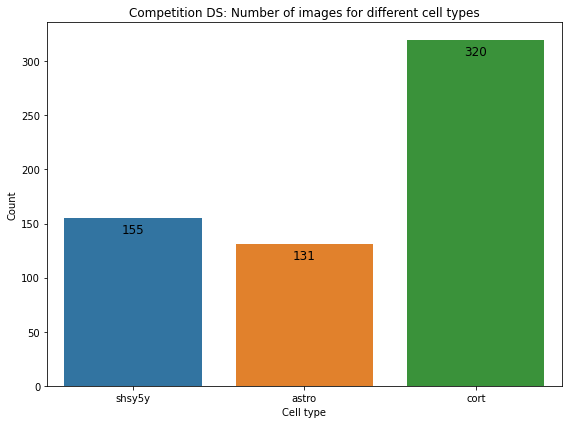

In [62]:
# display the statistics of training metadata

def display_statistics_of_ds(cell_type_cnt_dict, save=None):
    df = pd.DataFrame({'Cell type':cell_type_cnt_dict.keys(), 'Count':cell_type_cnt_dict.values()})

    plt.figure(figsize=(8,6))
    splot = sns.barplot(x='Cell type', y='Count', data=df)
    plt.title('Competition DS: Number of images for different cell types')
    # plt.bar_label(splot.containers[0])
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'),
                       (p.get_x()+p.get_width()/2, p.get_height()),
                       ha='center', va='center', size=12,
                       xytext=(0,-12), textcoords='offset points')
    if save:
        save_path = save / "results" / "distributions_of_cell_type_numbers.png"
        plt.savefig(save_path.as_posix())
    plt.tight_layout()
    plt.show()

display_statistics_of_ds(cell_type_cnt_dict, save=project_dir)